In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb
def vp(fp): return os.path.join('annot/Fig2S3_tss/', fp) # "verbose path"

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping


In [2]:
# (Kruesi et al., 2013) TSSs -- load
fp_ = 'wget/elifesciences.org/elife/download-suppl/2540/figure-1--source-data-2.media-2.xls/0/1.csv'
df_kruesi = pd.read_csv(fp_)
print('%d TSS records' % (len(df_kruesi)),)

m_ = df_kruesi['Wild-Type Embryo: TSS'] == df_kruesi['Wild-Type Embryo: TSS']
df_kruesi_emb_ = df_kruesi[m_].reset_index(drop=True)
print('%d Embryo TSSs' % (len(df_kruesi_emb_)),)

m_ = df_kruesi['Wild-Type L3: TSS'] == df_kruesi['Wild-Type L3: TSS']
df_kruesi_l3_ = df_kruesi[m_].reset_index(drop=True)
print('%d L3 TSSs' % (len(df_kruesi_l3_)),)

6353 TSS records
4246 Embryo TSSs
4513 L3 TSSs


In [3]:
df_kruesi_emb = pd.DataFrame()
df_kruesi_emb['chrom'] = df_kruesi_emb_['Chromosome']
df_kruesi_emb['start'] = list(map(int, df_kruesi_emb_['Wild-Type Embryo: TSS']))
df_kruesi_emb['end'] = df_kruesi_emb['start'] + 1
df_kruesi_emb['name'] = df_kruesi_emb_['Gene Name']
df_kruesi_emb['score'] = '.'
df_kruesi_emb['strand'] = list(map(lambda s: '+' if s == 1 else '-', df_kruesi_emb_['Strand']))
df_kruesi_emb['stage'] = 'embryo'
df_kruesi_emb.head()

,chrom,start,end,name,score,strand,stage
0,chrV,9247545,9247546,aat-2,.,-,embryo
1,chrX,2554029,2554030,aat-3,.,+,embryo
2,chrI,2577231,2577232,aat-5,.,-,embryo
3,chrX,10624265,10624266,abl-1,.,-,embryo
4,chrX,5099854,5099855,acn-1,.,-,embryo


In [4]:
df_kruesi_l3 = pd.DataFrame()
df_kruesi_l3['chrom'] = df_kruesi_l3_['Chromosome']
df_kruesi_l3['start'] = list(map(int, df_kruesi_l3_['Wild-Type L3: TSS']))
df_kruesi_l3['end'] = df_kruesi_l3['start'] + 1
df_kruesi_l3['name'] = df_kruesi_l3_['Gene Name']
df_kruesi_l3['score'] = '.'
df_kruesi_l3['strand'] = list(map(lambda s: '+' if s == 1 else '-', df_kruesi_l3_['Strand']))
df_kruesi_l3['stage'] = 'L3'
df_kruesi_l3.head()

,chrom,start,end,name,score,strand,stage
0,chrI,2577413,2577414,aat-5,.,-,L3
1,chrX,12794089,12794090,abf-6,.,+,L3
2,chrX,10624265,10624266,abl-1,.,-,L3
3,chrV,332655,332656,abt-4,.,-,L3
4,chrX,3798165,3798166,abu-10,.,+,L3


In [5]:
df_ = pd.concat([df_kruesi_emb, df_kruesi_l3], axis=0)\
    .sort_values(['chrom', 'start', 'end', 'strand']).reset_index(drop=True)

df_kruesi_emb_l3 = BedTool.from_dataframe(df_).merge(s=True, c='4,5,7', o='distinct,distinct,distinct').to_dataframe()
print('%d pooled Embryo+L3 records' % (len(df_kruesi_emb_l3),))

df_kruesi_emb_l3.columns = ('chrom', 'start', 'end', 'strand', 'name', 'score', 'stage')
df_kruesi_emb_l3['stage'].value_counts()

7016 pooled Embryo+L3 records


L3           2770
embryo       2503
L3,embryo    1743
Name: stage, dtype: int64

In [6]:
fp_ = vp('Kruesi2013_tss.bed')
write_gffbed(fp_,
    chrom = df_kruesi_emb_l3['chrom'],
    start = df_kruesi_emb_l3['start'],
    end = df_kruesi_emb_l3['end'],
    name = df_kruesi_emb_l3['name'],
    strand = df_kruesi_emb_l3['strand'],
    attr = df_kruesi_emb_l3[['name', 'stage']],
)

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13054 of 42245 sites with CV values via promoter annotation
26764 of 42245 sites with CV values via "associated gene"


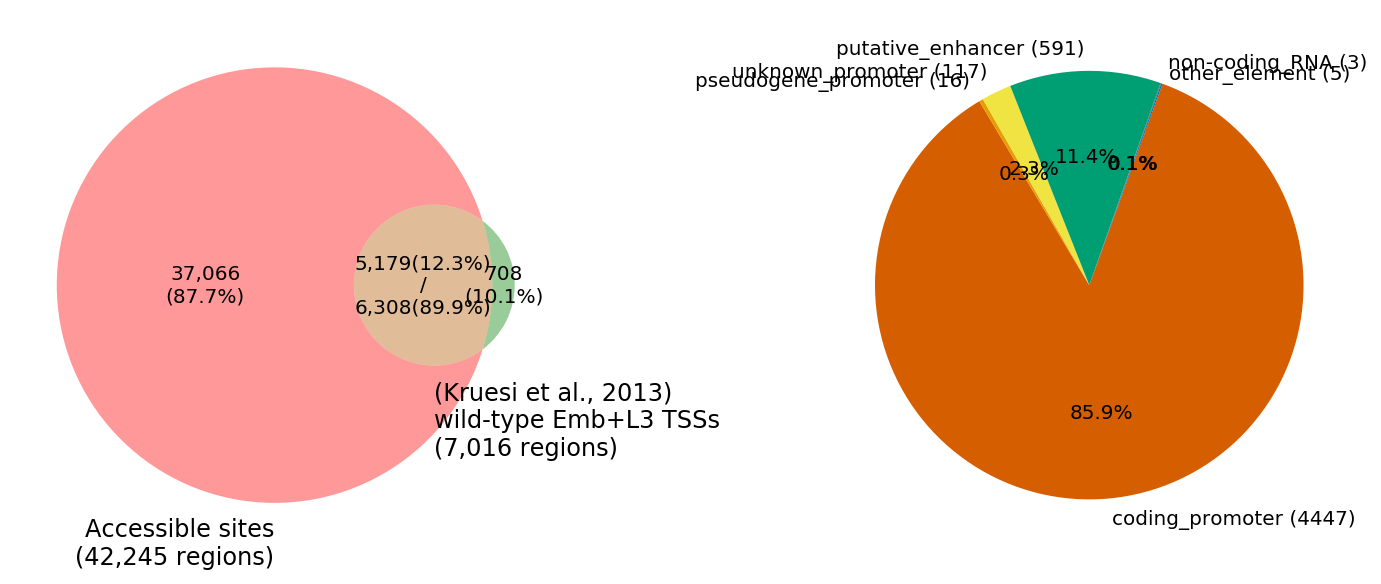

In [7]:
# (Kruesi et al., 2013)
df_regl_ = regl_Apr27(flank_len=150)[['chrom', 'start', 'end', 'annot']]

gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_regl_),
    BedTool.from_dataframe(df_kruesi_emb_l3[yp.NAMES_BED3]),
    label_a='Accessible sites',
    label_b='(Kruesi et al., 2013)\nwild-type Emb+L3 TSSs',
)

plt.figure(figsize=(12,6)).subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
gv.plot()

plt.subplot(1,2,2)
annot_count_ = gv.df_a_with_b['name'].value_counts()[config['annot']]
annot_count_.index = [
    'coding_promoter',
    'pseudogene_promoter',
    'unknown_promoter',
    'putative_enhancer',
    'non-coding_RNA',
    '\nother_element'
]
#plt.title('Annotation of %d accessible sites that overlap a TSS from (Kruesi et al., 2013)' % (len(gv.df_a_with_b),))
plt.pie(
    annot_count_.values,
    labels = ['%s (%d)' % (l, c) for l, c in annot_count_.iteritems()],
    colors=[yp.RED, yp.ORANGE, yp.YELLOW, yp.GREEN, '0.4', yp.BLUE],
    counterclock=False,
    startangle=70,
    autopct='%.1f%%',
);
plt.gca().set_aspect('equal')
#plt.savefig('annot/Fig2S5_tss/Kruesi2013_annot.pdf', bbox_inches='tight', transparent=True)

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13054 of 42245 sites with CV values via promoter annotation
26764 of 42245 sites with CV values via "associated gene"


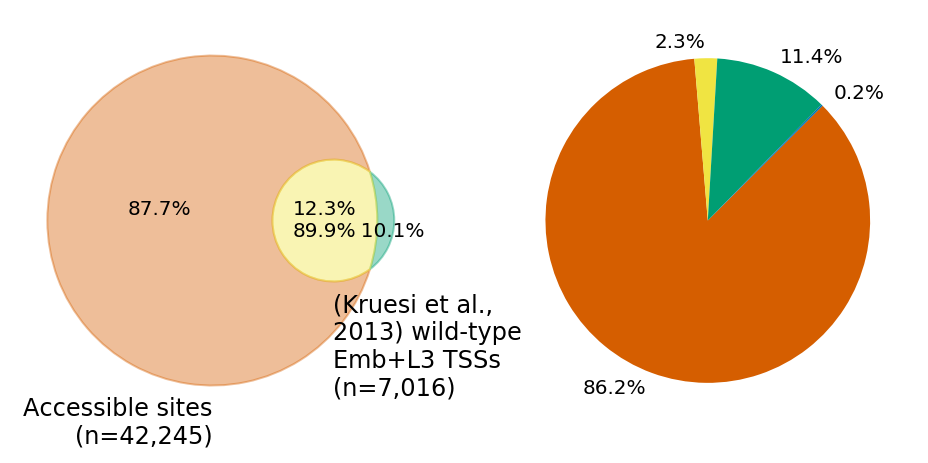

In [8]:
# (Kruesi et al., 2013)
df_regl_ = regl_Apr27(flank_len=150)[['chrom', 'start', 'end', 'annot']]

gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_regl_),
    BedTool.from_dataframe(df_kruesi_emb_l3[yp.NAMES_BED3]),
    label_a='Accessible sites',
    label_b='(Kruesi et al.,\n2013) wild-type\nEmb+L3 TSSs',
)

plt.figure(figsize=(8,4)).subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
v = gv.plot(style='compact')
v.get_patch_by_id('10').set_color(yp.RED)
v.get_patch_by_id('01').set_color(yp.GREEN)
v.get_patch_by_id('11').set_color(yp.YELLOW)
v.get_label_by_id('01').set_text('\n  10.1%')

plt.subplot(1,2,2)
d_reduced_ = collections.OrderedDict([
    ('coding_promoter', 'coding_promoter, pseudogene_promoter'),
    ('pseudogene_promoter', 'coding_promoter, pseudogene_promoter'),
    ('unknown_promoter', 'unknown_promoter'),
    ('putative_enhancer', 'putative_enhancer'),
    ('non-coding_RNA', 'other_element, non-coding_RNA'),
    ('other_element', 'other_element, non-coding_RNA'),
])

d_colour_ = collections.OrderedDict([
    ('coding_promoter, pseudogene_promoter', yp.RED),
    ('unknown_promoter', yp.YELLOW),
    ('putative_enhancer', yp.GREEN),
    ('other_element, non-coding_RNA', yp.BLUE),
])

gv.df_a_with_b['name_reduced'] = [*map(lambda a: d_reduced_[a], gv.df_a_with_b['name'])]
annot_count_ = gv.df_a_with_b['name_reduced'].value_counts()[d_colour_.keys()]

#plt.title('Annotation of %d accessible sites that overlap a TSS from (Chen et al., 2013)' % (len(gv.df_a_with_b),))
(patches, texts) = plt.pie(
    annot_count_.values,
    labels = yp.pct_(annot_count_.values),
    colors=d_colour_.values(),
    counterclock=False,
    startangle=45,
);
plt.gca().set_aspect('equal')
#plt.savefig(vp('Kruesi2013_annot.pdf'), bbox_inches='tight', transparent=True)
plt.savefig('annot_Apr27/Fig2S3B_Kruesi2013_annot.pdf', bbox_inches='tight', transparent=True)

In [9]:
# (Kruesi et al., 2013) TSSs now annotated as putative_enhancer
#fp_ = 'annot/FigA_overlaps/overlaps_Kruesi2013_TSS_to_putative_enhancer.bed'
#gv.df_a_with_b.query('name == "putative_enhancer"').to_csv(fp_, header=False, sep='\t', index=False)
#!wc -l {fp_}